# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Why CNN is required:
- ANN is not translation invariant i.e. translating the image may lead to different results. But a cat is cat in an image even if we shift its position
- Each pixel is considered independent of another but in images the pixels are not independent

# Showing that ANN is not translation invariant

In [2]:
base_folder = './data'
fashion_mnist_train = datasets.FashionMNIST(base_folder, download = True, train = True)
train_images, train_labels = fashion_mnist_train.data, fashion_mnist_train.targets
fashion_mnist_valid = datasets.FashionMNIST(base_folder, download = True, train = False)
valid_images, valid_labels = fashion_mnist_valid.data, fashion_mnist_valid.targets

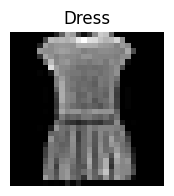

In [3]:
# Show that ANN is not translation invariant
idx = 3
img, lbl = train_images[idx], train_labels[idx]
plt.figure(figsize = (2,2))
plt.imshow(img, cmap = 'gray')
plt.title(fashion_mnist_train.classes[lbl])
plt.axis('off');

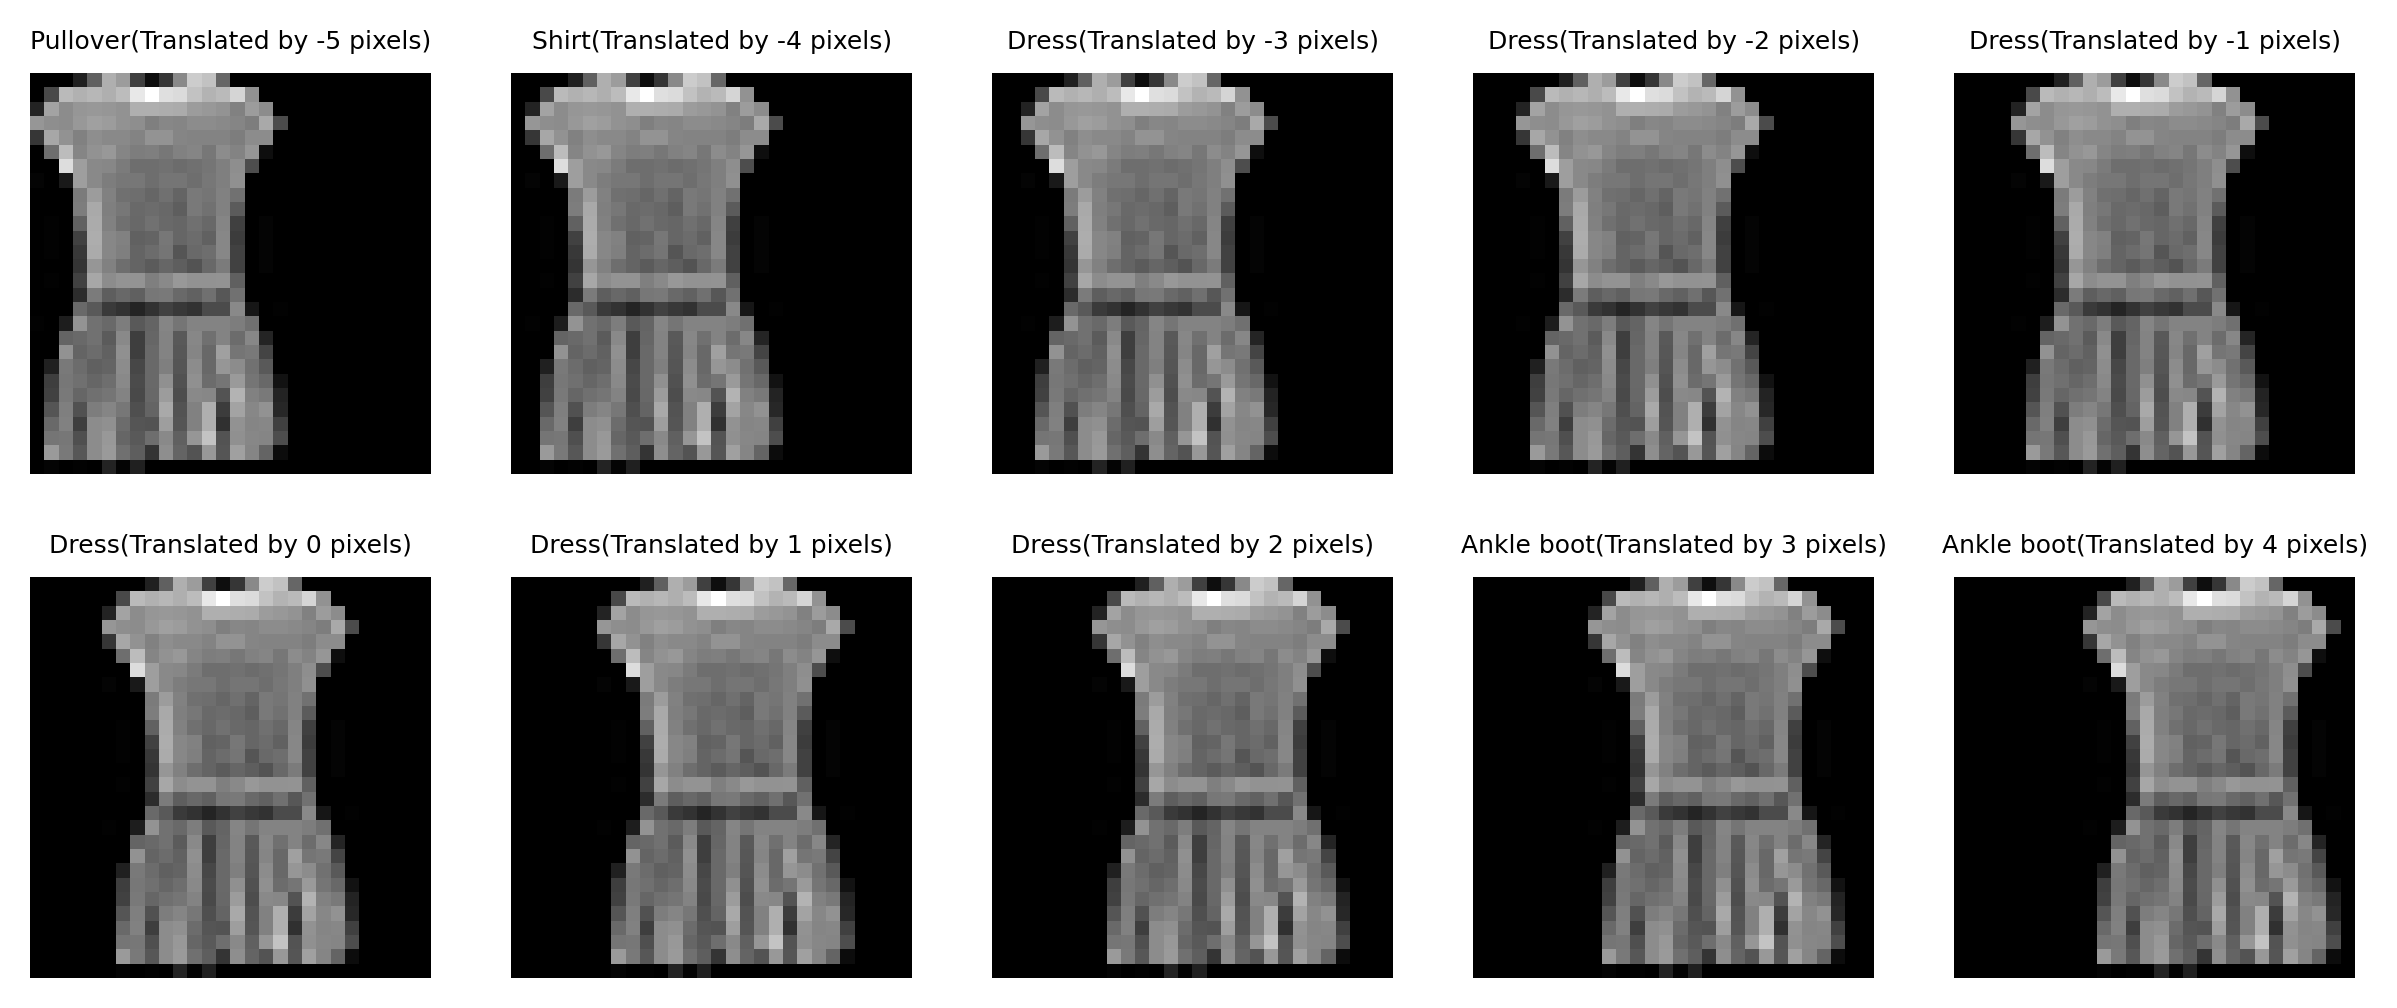

In [5]:
model = torch.jit.load('./saved_models/fmnist_ann.pt') # Replace string where model is stored after training Day_03 notebook

# Translating by n pixels (negative means left shift, positive means right shift)
n = 5
h,w = img.shape
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (10,4), dpi = 300)
idx = 0
for i in range(-n, n):
    translated_tensor = torch.zeros_like(img)
    if i < 0:
        translated_tensor[:,:w+i] = img[:,-i:]
    if i == 0:
        translated_tensor[:,:] = img[:, :]
    if i>0:
        translated_tensor[:,i:] = img[:,:-i]
        
    final_img_vector = translated_tensor.to(device).view(1, -1) / 255.
    preds = model(final_img_vector)
    label_predicted = fashion_mnist_train.classes[torch.max(preds, -1)[-1].item()]
    axes[idx//5, idx%5].imshow(translated_tensor, cmap = 'gray')
    axes[idx//5, idx%5].axis('off')
    axes[idx//5, idx%5].set_title(label_predicted+f'(Translated by {i} pixels)', fontsize = 6)
    idx+=1

As it is evident from above that the translation causes the model to wrongly predict the class of dress (without any other change). So ANN is not translation invariant

# Convolutional Neural Network

Convolutional Neural network generally comprises of two operations:
- Convolutional Operation (Obviously)
- Pooling Operation

a. In __Convolutional operation__ we have a filter (kernel) which is a n * n matrix and we slide it over our input (m * m) matrix and do matrix multiplication of the overlapping area of input with filter to generate a scalar. Output dimension might change while performing this operation which can be controlled via:

    - Stride: This determines how many pixels to skip while sliding the kernel over input
    - Padding: Adds a boundary around the input image
    
__NOTE:__ For an input with c channels the filter size also have c channels to perform convolution

b. In __Pooling operation__ we perform similar steps like convolutional operation but generally instead of doing matrix multiplication, we find maximum value, minimum value or average value over nxn region (n being the size of filter).

Generally for an input image of h * w * c after performing convolutional operation with __k__ filters of filter size of __n__ and stride of __s__ and padding of __p__ we get:

$$c_{out} = k$$

$$
h_{out} = \lfloor \frac{h - n + 2*p}{s} \rfloor + 1
$$

$$
w_{out} = \lfloor \frac{w - n + 2*p}{s} \rfloor + 1
$$

## Convolutional Operation

In [49]:
def convolutional_operation(input_, filter_, stride = 1, padding = 0):
    # Only added 0 padding in this code and input_ is without any channels for simplicity
    padded_shape = input_.shape[0] + 2*padding, input_.shape[1] + 2*padding
    padded_input = torch.zeros(padded_shape)
    h, w = padded_input.shape
    if padding > 0:
        padded_input[padding:-padding,padding:-padding] = input_[:, :]
    else:
        padded_input[:, :] = input_[:, :]
    if filter_.shape[0] != filter_.shape[1]:
        raise Exception('Filter must be square in shape')
    n = filter_.shape[0]
    h_out, w_out = (h - n)//stride + 1, (w - n)//stride + 1
    output_tensor = torch.zeros(h_out, w_out)
    current_row = 0
    for i in range(h_out):
        current_col = 0
        for j in range(w_out):
            region = padded_input[current_row:current_row + n, current_col:current_col + n]
            subset_conv = torch.multiply(region, filter_).sum().item()
            output_tensor[i, j] = subset_conv
            current_col += stride
        current_row += stride
    return output_tensor

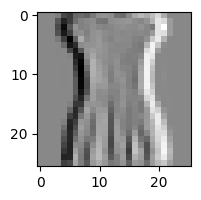

In [58]:
idx = 3
input_tensor = train_images[idx]
# vertical edge detection filter
f = torch.tensor([[1, 0, -1], 
                  [1, 0, -1], 
                  [1, 0, -1]])
output = convolutional_operation(input_tensor, f, 1, 0)
plt.figure(figsize = (2,2))
plt.imshow(output, cmap = 'gray');

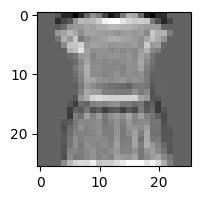

In [59]:
idx = 3
input_tensor = train_images[idx]
# Horizontal edge detection filter
f = torch.tensor([[1, 1, 1], 
                  [0, 0, 0], 
                  [-1, 0, -1]])
plt.figure(figsize = (2,2))
output = convolutional_operation(input_tensor, f, 1, 0)
plt.imshow(output, cmap = 'gray');

So shown above is horizontal and vertical edge detection. It was tedious to come up with filters performing the task desired therefore this learning of weights can be done via CNN which chooses appropriate weights for filter for the given task

## Pooling Operation

In [63]:
def pooling_operation(input_, filter_size = 2, stride = 1, padding = 0):
    # Only added 0 padding in this code and input_ is without any channels for simplicity
    # Also only max pooling is applied
    padded_shape = input_.shape[0] + 2*padding, input_.shape[1] + 2*padding
    padded_input = torch.zeros(padded_shape)
    h, w = padded_input.shape
    if padding > 0:
        padded_input[padding:-padding,padding:-padding] = input_[:, :]
    else:
        padded_input[:, :] = input_[:, :]
    n = filter_size
    h_out, w_out = (h - n)//stride + 1, (w - n)//stride + 1
    output_tensor = torch.zeros(h_out, w_out)
    current_row = 0
    for i in range(h_out):
        current_col = 0
        for j in range(w_out):
            region = padded_input[current_row:current_row + n, current_col:current_col + n]
            subset_conv = torch.max(region)
            output_tensor[i, j] = subset_conv
            current_col += stride
        current_row += stride
    return output_tensor

torch.Size([14, 14])


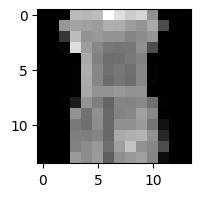

In [64]:
idx = 3
input_tensor = train_images[idx]
output = pooling_operation(input_tensor, 2, 2, 0)
print(output.shape)
plt.figure(figsize = (2,2))
plt.imshow(output, cmap = 'gray');

Pooling reduces the spatial dimension of image. It looks in a region and checks which is maximally activated like an aggregation operation in a region